## Notebook that compare different atmospheric density models 
- Poliastro exponential model: an approximation, which as we can observe is very far from the more complex model at altitudes around 500km (difference order of magnitude: e15)
- Coe76 model extracted from Poliastro (standard US model, static, does not depend on time)
- ATMOS library (but does not go too far in time)
- New model taken from literature depending on solar activity data

In [ ]:
import numpy as np
import sys
from typing import Tuple, Callable

from astropy import units as u
from astropy.time import Time, TimeDelta
from poliastro.bodies import Earth

from poliastro.constants import rho0_earth, H0_earth, J2000
from poliastro.earth.atmosphere import COESA76

from pyatmos import coesa76

from datetime import datetime
from dateutil.relativedelta import relativedelta

from astropy.coordinates import (
    GCRS,
    ITRS,
    CartesianRepresentation,
    SphericalRepresentation,
)

sys.path.insert(0, "../")
from digital_twin.constants import earth_R

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime

from scipy.signal import lfilter

sys.path.insert(0, "../")
from digital_twin.plotting import plot_1d, find_x_scale, plot_1d_multiple
from digital_twin.constants import earth_R
from digital_twin.orbit_propagator import Coesa76, NRLMSISE00, SolarActivity, JB2008

from pyatmos import download_sw_jb2008, read_sw_jb2008
from pyatmos import jb2008

from pyatmos import download_sw_nrlmsise00, read_sw_nrlmsise00
from pyatmos import nrlmsise00

In [3]:
# EARTH ATMOSPHERE CONSTANTS for the simple exponential atmosphere model
rho0 = rho0_earth.to(u.kg / u.km**3)  # (kg/km^3)
H0 = H0_earth.to(u.km)  # (km)

# COMPLEX ATMOSPHERIC MODEL
atmosphere_model = COESA76()

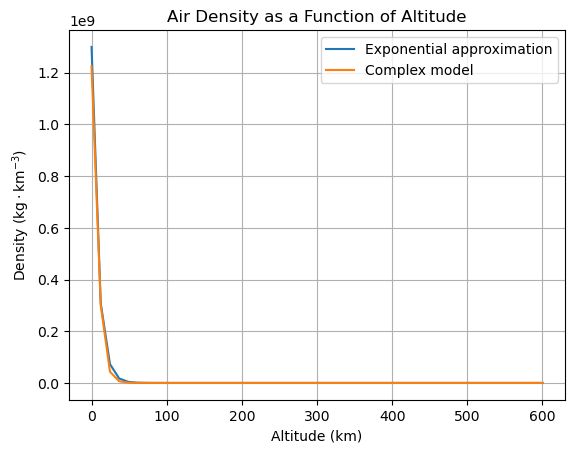

In [11]:
x = np.linspace(0, 600, 50)

y_1 = rho0.value * np.exp(-(x / H0.value))
y_2 = []
for xi in x:
    y_2.append(atmosphere_model.density(xi * u.km).to_value(u.kg / u.km**3))
y_2 = np.array(y_2)

plt.figure()
plt.title(r"Air Density as a Function of Altitude")
plt.plot(x, y_1, label="Exponential approximation")
plt.plot(x, y_2, label="Complex model")
plt.legend()
plt.xlabel(r"Altitude (km)")
# plt.ylabel(r"Density ($kg.km^(-3)$)")
plt.ylabel(r"Density ($\mathrm{kg \cdot km^{-3}}$)")
plt.grid()
plt.show()

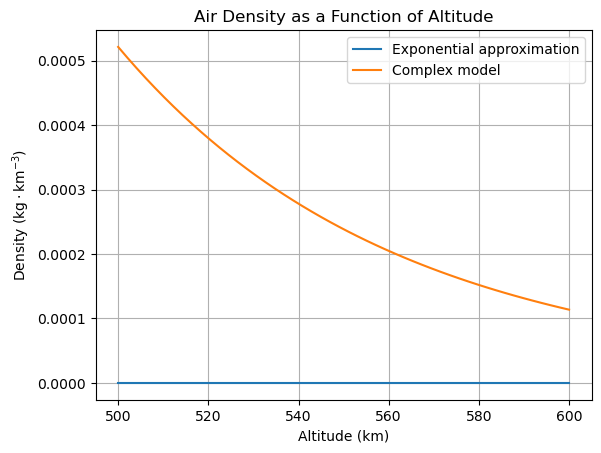

Density at 550 km (kg/m^3):  5.212859332411656e-13
Density at 550 km (kg/km^3):  0.0005212859332411655


In [12]:
x_zoom = np.linspace(500, 600, 50)

y_1_zoom = rho0.value * np.exp(-(x_zoom / H0.value))
y_2_zoom = []
for xi in x_zoom:
    y_2_zoom.append(atmosphere_model.density(xi * u.km).to_value(u.kg / u.km**3))
y_2_zoom = np.array(y_2_zoom)

plt.figure()
plt.title(r"Air Density as a Function of Altitude")
plt.plot(x_zoom, y_1_zoom, label="Exponential approximation")
plt.plot(x_zoom, y_2_zoom, label="Complex model")
plt.legend()
plt.xlabel(r"Altitude (km)")
plt.ylabel(r"Density ($\mathrm{kg \cdot km^{-3}}$)")
plt.grid()
plt.show()

print(
    "Density at 550 km (kg/m^3): ",
    atmosphere_model.density(500 * u.km).to_value(u.kg / u.m**3),
)
print(
    "Density at 550 km (kg/km^3): ",
    atmosphere_model.density(500 * u.km).to_value(u.kg / u.km**3),
)

## Other library named ATMOS

In [ ]:
# time variable
t_wanted_str = "2028-05-01 09:00:00.000"
t_max_str = "2024-12-01 00:00:00.000"

t_wanted = datetime.strptime(t_wanted_str, "%Y-%m-%d %H:%M:%S.%f")
t_max = datetime.strptime(t_max_str, "%Y-%m-%d %H:%M:%S.%f")
cycle = relativedelta(years=11)

# go back in time with solar cycles
t = t_wanted
while t > t_max:
    t = t - cycle
epoch = t.strftime("%Y-%m-%d %H:%M:%S.%f")
print(epoch)

# altitude variable:
altitude = 500 * u.km

# position variable
rr = np.array([4000, 4000, 4000])
raw_xyz = CartesianRepresentation(rr)
raw_obstime = epoch
gcrs_xyz = GCRS(
    raw_xyz, obstime=raw_obstime, representation_type=CartesianRepresentation
)
itrs_xyz = gcrs_xyz.transform_to(
    ITRS(obstime=raw_obstime)
)  # Converts raw coordinates to ITRS ones.

itrs_latlon = itrs_xyz.represent_as(SphericalRepresentation)
lat = itrs_latlon.lat.to_value(u.deg)
lon = itrs_latlon.lon.to_value(u.deg)
alt = np.linalg.norm(rr) - earth_R.value
print(lat)
print(lon)
print(alt)

In [ ]:
# coesa76
coesa76_geom = coesa76([alt])  # geometric altitudes by default
print(coesa76_geom.rho * (u.kg / u.m**3))  # [kg/m^3]

# for altitude variable,  we observe that it gives the same results
# as poliastro coesa76 model => good sanity check

In [ ]:
# Download or update the space weather file from https://sol.spacenvironment.net
swfile = download_sw_jb2008()
# Read the space weather data
swdata = read_sw_jb2008(swfile)

jb08 = jb2008(epoch, (lat, lon, alt), swdata)
print(jb08.rho)  # [kg/m^3]

In [ ]:
# Download or update the space weather file from www.celestrak.com
swfile = download_sw_nrlmsise00()
# Read the space weather data
swdata = read_sw_nrlmsise00(swfile)

nrl00 = nrlmsise00(epoch, (lat, lon, alt), swdata)
print(nrl00.rho)  # [kg/m^3]

In [30]:
## comparison

print("COESA 76: ", coesa76_geom.rho)
print("jb2008: ", jb08.rho)
print("nrlmsise00: ", nrl00.rho)

COESA 76:  [2.38213763e-13]
jb2008:  1.0502219495260647e-13
nrlmsise00:  8.742714709295974e-14


## New model based on solar activity

In [86]:
F10_7_array = np.load("DRAMA_results/500km_sa_not_cst_F10.npy")
Ap_array = np.load("DRAMA_results/500km_sa_not_cst_Ap.npy")
times_array = np.load("DRAMA_results/500km_sa_not_cst_dates_sa.npy", allow_pickle=True)

In [ ]:
def get_index_and_values(iso_date_str, times, F10, Ap):
    """
    Given an ISO date string, find the index of the corresponding date (ignoring time)
    in the times array and return the F10 and Ap values for that date.

    Parameters:
    - iso_date_str (str): The ISO formatted date string (e.g., '2028-04-22').
    - times (np.ndarray): Array of `astropy.time.Time` objects.
    - F10 (np.ndarray): Array of F10 values.
    - Ap (np.ndarray): Array of Ap values.

    Returns:
    - (index, f10_value, ap_value): Tuple with the index of the matched date,
      and the corresponding F10 and Ap values.
    """
    target_date = Time(
        iso_date_str, format="iso"
    ).ymdhms  # Extracts year, month, day tuple
    for i, time in enumerate(times):
        time_date = time.ymdhms
        if (time_date.year, time_date.month, time_date.day) == (
            target_date.year,
            target_date.month,
            target_date.day,
        ):
            return i, F10[i], Ap[i]
    raise ValueError(f"Date {iso_date_str} not found in times array.")


def calculate_density(F10_7, Ap, alt):
    T = 900 + 2.5 * (F10_7 - 70) + 1.5 * Ap  # [Kelvin]
    m = 27 - 0.012 * (alt - 200)
    H = T / m  # [km]
    rho = 6 * 10 ** (-10) * np.exp(-(alt - 175) / H)  # [kg m‐3]
    return rho

In [ ]:
# example usage
iso_date_str = "2056-04-22 12:00:00"
alt = 500

# coesa76
coesa76_rho = coesa76([alt])  # geometric altitudes by default
print("Coesa76 model:", coesa76_rho.rho * (u.kg / u.m**3))  # [kg/m^3]

# New model (https://www.osti.gov/servlets/purl/1124870/) based on solar activity data
index, f10_7, ap = get_index_and_values(
    iso_date_str, times_array, F10_7_array, Ap_array
)
print(f"F10: {f10_7}, Ap: {ap}")
new_model_rho = calculate_density(f10_7, ap, alt)
print("New model:", new_model_rho * (u.kg / u.m**3))  # [kg/m^3]

# second example, fix solar activity values based on DRAMA constants
f10_7 = 146
ap = 15
new_model_rho = calculate_density(f10_7, ap, alt)
print("New model (2):", new_model_rho * (u.kg / u.m**3))  # [kg/m^3]

## Compare atmosphere models for a simulation of 1 year

In [10]:
# data

results_folder = "comparison_atmosphere_models_data/"

times_nrl00 = np.load(results_folder + "times_nrl00.npy")
altitudes_nrl00 = np.load(results_folder + "altitude_nrl00.npy")

times_jb2008 = np.load(results_folder + "times_jb2008.npy")
altitudes_jb2008 = np.load(results_folder + "altitude_jb2008.npy")

times_coesa76 = np.load(results_folder + "times_coesa76.npy")
altitudes_coesa76 = np.load(results_folder + "altitude_coesa76.npy")

# smoothen altitudes
n = 20  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
# yy = lfilter(b, a, y)

altitudes_jb2008_f = lfilter(b, a, altitudes_jb2008)[20:]
altitudes_nrl00_f = lfilter(b, a, altitudes_nrl00)[20:]
altitudes_coesa76_f = lfilter(b, a, altitudes_coesa76)[20:]

times_coesa76_f = times_coesa76[20:]
times_jb2008_f = times_jb2008[20:]
times_nrl00_f = times_nrl00[20:]

31536000.0


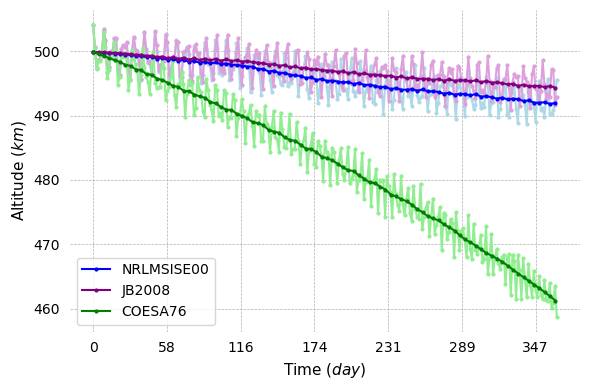

In [ ]:
duration_sim = TimeDelta(times_nrl00[-1])
print(duration_sim)
x_label, x_label_f = find_x_scale(duration_sim)

steps = [100, 100, 100, 300, 300, 300]
labels = [
    "",
    "",
    "",
    r"NRLMSISE00",
    r"JB2008",
    r"COESA76",
]
colors = ["lightblue", "plum", "lightgreen", "blue", "purple", "green"]
xs = [
    times_nrl00,
    times_jb2008,
    times_coesa76,
    times_nrl00_f,
    times_jb2008_f,
    times_coesa76_f,
]
# the + 5 is a bit of cheating. it is because of the filter, i had to discard the first 20 data points
# so it appeared that the altitude was lower than that it is!
ys_altitudes = [
    altitudes_nrl00 + 5,
    altitudes_jb2008 + 5,
    altitudes_coesa76 + 5,
    altitudes_nrl00_f + 5,
    altitudes_jb2008_f + 5,
    altitudes_coesa76_f + 5,
]


plot_1d_multiple(
    xs,
    ys_altitudes,
    "",  # "Spacecraft Altitude Over Time",
    x_label,
    r"Altitude ($km$)",
    colors=colors,
    labels=labels,
    step=steps,
    fill_under=False,
    remove_box=True,
    show=True,
    x_label_f=x_label_f,
    save_filename=results_folder + "_altitude_comparison_1_year.jpg",
)

## Compare lifetime of satellite with JB2008 model, NRLMSISE00 model, and DRAMA

In [8]:
# DRAMA data
path_DRAMA = "DRAMA_results/" + "500km_sa_not_cst_3"
times_DRAMA = np.load(path_DRAMA + "_times.npy")
altitudes_DRAMA = np.load(path_DRAMA + "_altitudes.npy")

# NRLMSISE00 data
path_simulation = "comparison_atmosphere_models_data/"
times_nrl00 = np.load(path_simulation + "times_lifetime_nrl00.npy")
altitudes_nrl00 = np.load(path_simulation + "altitude_lifetime_nrl00.npy")


# JB2008 data
times_jb2008 = np.load(path_simulation + "times_lifetime_jb2008.npy")
altitudes_jb2008 = np.load(path_simulation + "altitude_lifetime_jb2008.npy")

# Solar Activity
times_solar_activity = np.load(path_simulation + "times_lifetime_solar_activity.npy")
altitudes_solar_activity = np.load(
    path_simulation + "altitude_lifetime_solar_activity.npy"
)

# COESA76
times_coesa76 = np.load(path_simulation + "times_lifetime_coesa76.npy")
altitudes_coesa76 = np.load(path_simulation + "altitude_lifetime_coesa76.npy")

# Smoothen altitudes
n = 20  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

altitudes_nrl00_f = lfilter(b, a, altitudes_nrl00)[20:]
times_nrl00_f = times_nrl00[20:]

altitudes_jb2008_f = lfilter(b, a, altitudes_jb2008)[20:]
times_jb2008_f = times_jb2008[20:]

altitudes_solar_activity_f = lfilter(b, a, altitudes_solar_activity)[20:]
times_solar_activity_f = times_solar_activity[20:]

altitudes_coesa76_f = lfilter(b, a, altitudes_coesa76)[20:]
times_coesa76_f = times_coesa76[20:]

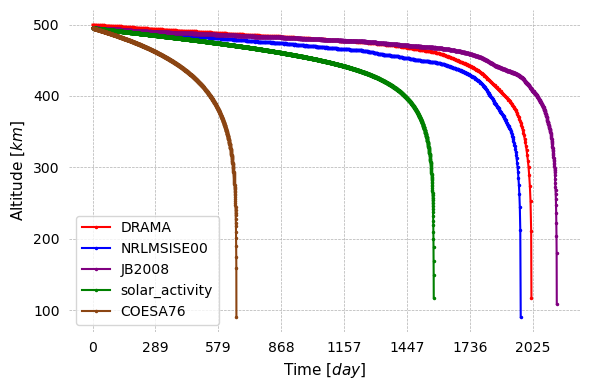

In [9]:
duration_sim_DRAMA = TimeDelta(times_DRAMA[-1])
duration_nrl00 = TimeDelta(times_nrl00[-1])
duration_jb2008 = TimeDelta(times_jb2008[-1])
duration_solar_activity = TimeDelta(times_solar_activity[-1])
duration_coesa76 = TimeDelta(times_coesa76[-1])
duration = max(
    duration_nrl00,
    duration_jb2008,
    duration_sim_DRAMA,
    duration_solar_activity,
    duration_coesa76,
)
x_label, x_label_f = find_x_scale(duration)

steps = [1, 300, 100, 50, 50]
labels = [
    "DRAMA",
    "NRLMSISE00",
    "JB2008",
    "solar_activity",
    "COESA76",
]
colors = ["red", "blue", "purple", "green", "saddlebrown"]
xs = [
    times_DRAMA,
    times_nrl00_f,
    times_jb2008_f,
    times_solar_activity_f,
    times_coesa76_f,
]
ys = [
    altitudes_DRAMA,
    altitudes_nrl00_f,
    altitudes_jb2008_f,
    altitudes_solar_activity_f,
    altitudes_coesa76_f,
]

plot_1d_multiple(
    xs,
    ys,
    "",
    x_label,
    r"Altitude $\left[km\right]$",
    colors=colors,
    labels=labels,
    step=steps,
    fill_under=False,
    remove_box=True,
    show=True,
    x_label_f=x_label_f,
    save_filename=path_simulation + "lifetime_comparison.jpg",
    markersize_plot=3,
)

## Plor Density depending on altitude at different times (for different solar activity values)

In [ ]:
path_simulation = "comparison_atmosphere_models_data/"

# instantiate models (defined in atmosphere_model.py)
coesa76_model = Coesa76()
nrl00_model = NRLMSISE00(path="../../data/atmosphere_data/NRLMSISE00/")
solar_activity_model = SolarActivity(
    path_f10="../../data/atmosphere_data/solar_activity/F10.npy",
    path_ap="../../data/atmosphere_data/solar_activity/ap.npy",
    path_times="../../data/atmosphere_data/solar_activity/dates_sa.npy",
)
jb2008_model = JB2008(path="../data/atmosphere_data/JB2008/")

# define altitudes and dates
R = earth_R.to_value()  # in km
altitudes = np.arange(115, 501)  # Altitudes in km
x = R + altitudes  # x-coordinate
y = np.zeros_like(altitudes)  # y-coordinate
z = np.zeros_like(altitudes)  # z-coordinate
positions = np.stack((x, y, z), axis=1)
print(positions)

dates = [
    "2030-05-01 09:00:00.000",
    "2033-05-01 09:00:00.000",
    "2035-05-01 09:00:00.000",
]  # low and high solar activity

density_coesa76 = np.zeros((len(dates), len(altitudes)))
density_nrl00 = np.zeros((len(dates), len(altitudes)))
density_jb2008 = np.zeros((len(dates), len(altitudes)))
density_solar_activity = np.zeros((len(dates), len(altitudes)))

for i, date in enumerate(dates):
    for j, position in enumerate(positions):
        density_coesa76[i][j] = coesa76_model.get_density(date, position).to_value()
        density_nrl00[i][j] = nrl00_model.get_density(date, position).to_value()
        density_jb2008[i][j] = jb2008_model.get_density(date, position).to_value()
        density_solar_activity[i][j] = solar_activity_model.get_density(
            date, position
        ).to_value()

In [3]:
def plot_1d_multiple_tmp(
    x: list,
    y: list,
    title: str,
    xlabel: str,
    ylabel: str,
    colors: list,
    labels: list,
    step: list,
    fill_under: bool = True,
    remove_box: bool = True,
    x_range: tuple = None,
    y_range: tuple = None,
    scatter: bool = False,
    x_label_f: Callable = None,
    custom_y_ticks: bool = False,
    y_ticks: np.ndarray = None,
    y_tick_labels: np.ndarray = None,
    custom_x_ticks: bool = False,
    x_ticks: np.ndarray = None,
    x_tick_labels: np.ndarray = None,
    save_filename: str = None,
    show: bool = True,
    markersize_plot: int = 4,
    date_x_axis: bool = False,
    date_interval: int = 1,
    date_format: str = "%d/%m/%Y",
    log_y_scale: bool = False,
) -> None:
    """Function for general plotting in 2d with x and y arrays as input for MULTIPLE PLOTS on the same ax."""
    nb_plots = len(y)  # = len(x)

    # Downsample the x and y arrays
    x_downsampled = []
    y_downsampled = []
    for i in range(nb_plots):
        x_downsampled.append(x[i][:: step[i]])
        y_downsampled.append(y[i][:: step[i]])

    # Create the plot
    plt.figure(figsize=(6, 4))
    if scatter:
        for i in range(nb_plots):
            plt.scatter(
                x_downsampled[i],
                y_downsampled[i],
                marker=".",
                color=colors[i],
                s=10,
                label=labels[i],
            )
    else:
        for i in range(nb_plots):
            plt.plot(
                x_downsampled[i],
                y_downsampled[i],
                marker=".",
                linestyle="-",
                color=colors[i],
                markersize=markersize_plot,
                label=labels[i],
            )

    # Beautifying the plot
    if log_y_scale:
        plt.yscale("log")
    plt.title(title, fontsize=13, fontweight="medium")
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Setting x and y axis ranges if provided
    if x_range is not None:
        plt.xlim(x_range)  # Set the x-axis range (tuple)
    if y_range is not None:
        plt.ylim(y_range)  # Set the y-axis range (tuple)

    # Adding customizations
    ax = plt.gca()  # Get the current axis
    if x_label_f is not None:
        ax.xaxis.set_major_formatter(FuncFormatter(x_label_f))
    if custom_y_ticks:
        if y_ticks is None or y_tick_labels is None:
            raise ValueError("Must provide y ticks and y tick labels")
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_tick_labels)
    if custom_x_ticks:
        if x_ticks is None or x_tick_labels is None:
            raise ValueError("Must provide x ticks and x tick labels")
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_tick_labels)
    if fill_under:
        for i in range(nb_plots):
            plt.fill_between(
                x_downsampled[i], y_downsampled[i], color="light" + colors[i], alpha=0.3
            )
    if remove_box:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        # Remove ticks
        ax.yaxis.set_ticks_position("none")
        ax.xaxis.set_ticks_position("none")
    else:
        ax.spines["top"].set_color((0.8, 0.8, 0.8))
        ax.spines["right"].set_color((0.8, 0.8, 0.8))
        ax.spines["left"].set_color((0.8, 0.8, 0.8))
        ax.spines["bottom"].set_color((0.8, 0.8, 0.8))

    # if want to have dates as the x axis
    if date_x_axis:
        # Set major locator to show every other day (or adjust as needed)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=date_interval))
        ax.xaxis.set_major_formatter(
            mdates.DateFormatter(date_format)
        )  # display the year only
        plt.xticks(rotation=45)

    plt.legend()

    # Show the plot
    plt.tight_layout()
    if save_filename is not None:
        plt.savefig(save_filename, dpi=300)

    if show:
        plt.show()
    else:
        plt.close()

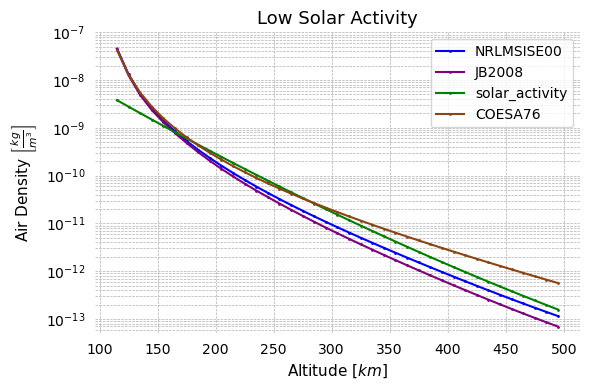

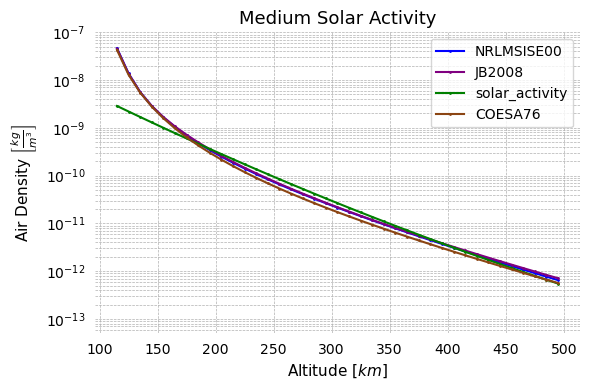

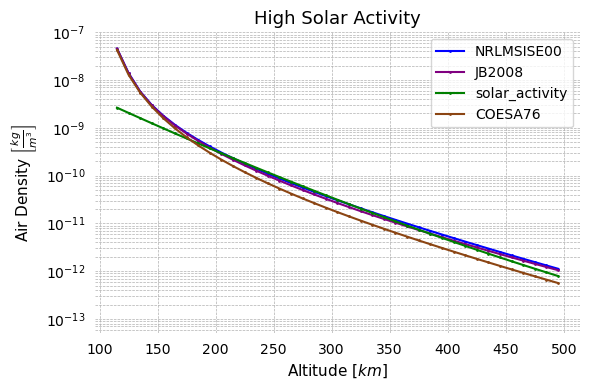

In [7]:
# plot results
steps = [10, 10, 10, 10]
labels = ["NRLMSISE00", "JB2008", "solar_activity", "COESA76"]
colors = ["blue", "purple", "green", "saddlebrown"]
x_label = r"Altitude $\left[km\right]$"

index = 0
solar_activity_intensities = ["Low", "Medium", "High"]
for index, solar_activity_intensity in enumerate(solar_activity_intensities):
    xs = [altitudes, altitudes, altitudes, altitudes]
    ys = [
        density_nrl00[index],
        density_jb2008[index],
        density_solar_activity[index],
        density_coesa76[index],
    ]

    plot_1d_multiple_tmp(
        x=xs,
        y=ys,
        title=solar_activity_intensity + " Solar Activity",
        xlabel=r"Altitude $\left[km\right]$",
        ylabel=r"Air Density $\left[\frac{kg}{m^3}\right]$",
        colors=colors,
        labels=labels,
        step=steps,
        fill_under=False,
        remove_box=True,
        y_range=[5 * 10 ** (-14), 10 ** (-7)],
        show=True,
        save_filename=path_simulation
        + "density_comparison_"
        + solar_activity_intensity
        + ".jpg",
        log_y_scale=True,
        markersize_plot=2,
    )